# Simple Neural Network Template
Goal of this notebook is to avoid rewrinting code for Neural Networks with tabular data


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from torchinfo import summary

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from tqdm import tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The dataset

## Data Loading and Split

In [5]:
# Use a random df instead of df = pd.read_csv("") 
df = pd.DataFrame(np.random.randint(0,100,size=(1000, 4)), columns=["f1","f2","f3","y"])

# list of columns used as features and as target
feaures = ["f1","f2","f3"]
target = ["y"]

df.head()


,f1,f2,f3,y
0,1,96,12,7
1,24,99,88,10
2,96,45,85,38
3,56,45,32,34
4,72,99,90,5


In [6]:
# if needed, spit the data into train\validation and test set
features = df[feaures].values
targets = df[target].values

# Split the dataset into training and temp sets (85% train, 15% temp)
features_train, features_temp, targets_train, targets_temp = train_test_split(
    features, targets, test_size=0.3, random_state=0
)

# Further split the temp set into validation and test sets 
features_val, features_test, targets_val, targets_test = train_test_split(
    features_temp, targets_temp, test_size=0.5, random_state=0
)

# Note that from now we are using numpy array of dimension (sample, features) 
print(f"Shape of the training feature set:\t {features_train.shape}")
print(f"Shape of the training target set:\t {targets_temp.shape}")


Shape of the training feature set:	 (700, 3)
Shape of the training target set:	 (300, 1)


## Scaling

Scaling is important for NN traing:
- NN are trained with gradient-based optimization. If input features have very different ranges (e.g., one is in [0,1], another in [0,1000]), the gradients become unbalanced
- Weights are usually initialized with small random values. If inputs vary a lot in scale, some neurons saturate (e.g., sigmoid stuck at 0 or 1), killing gradients.
- A feature with large values might artificially look more important, skewing learning.

Here the most common methods from sklearn: 
| Method         | Formula                  | Best For                        | Sensitive to Outliers |
|----------------|--------------------------|---------------------------------|-----------------------|
| StandardScaler | (x - μ) / σ             | General NN input, Gaussian data |  Yes                |
| MinMaxScaler   | (x - min) / (max - min) | Images, bounded features        |  Yes                |
| RobustScaler   | (x - median) / IQR      | Skewed data, outliers present   |  No                 |
| MaxAbsScaler   | x / max(abs(x))         | Sparse data, [-1,1] scaling     |  Yes                |

For sake of semplicity:

- Images → MinMax (0–1)
- General tabular → StandardScaler
- Outlier-heavy data → RobustScaler

In [7]:
scaler = StandardScaler()
# remember to fit only of training data
scaler.fit(features_train) 

# Transform the training, validation, and test sets
features_train = scaler.transform(features_train)
features_val = scaler.transform(features_val)
features_test = scaler.transform(features_test)

## DataSet & DataLoader

In PyTorch, data handling is split into two complementary abstractions. A Dataset defines what the data is and how to access a single sample, while a DataLoader defines how to efficiently serve that data to a model in batches. This separation allows you to keep the logic of accessing data independent from the logic of batching, shuffling, and parallelizing.

**Dataset**: defines the data access pattern.
- Implements __getitem__(index) → returns a single (features, target) pair.
- Implements __len__() → reports dataset size (for map-style datasets).
- Can be map-style (random access) or iterable (streaming).

**DataLoader**: orchestrates data delivery.
- Wraps a Dataset and produces mini-batches.
- Handles shuffling, parallel sample loading (num_workers), and batch collation into tensors.
- Provides an iterator over batches, enabling efficient training loops.

For tabular data, we have 2 possible options for the creation of the dataset.


* **Custom Dataset** ([docs](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html))
    - subclass `torch.utils.data.Dataset` and must implement `__len__` / `__getitem__`.
    -  Flexible: supports preprocessing (scaling, encoding, imputation), lazy loading from disk, and any custom logic for accessing samples.
    - Needed for non-ram fitting dataset
* **`TensorDataset`** – lightweight wrapper around `(X_tensor, y_tensor)` when data is already preprocessed and fits in memory. 
    -  Minimal boilerplate, but no support for on-the-fly transforms or complex loading.


Would you like me to now provide **minimal code examples** for both in the same format (so you can compare side by side)?



In [8]:
train_dataset = TensorDataset(torch.Tensor(features_train), torch.Tensor(targets_train))
val_dataset = TensorDataset(torch.Tensor(features_val), torch.Tensor(targets_val))


BATCH_SIZE = 32
# Create DataLoaders for training, validation, and testing sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Your Neural network

## Define It

When creating a custom neural network by subclassing `nn.Module`, the class typically includes **required components** and **optional but common patterns**.

### Required Components
- **`__init__(self, ...)`**  
  - Purpose: define all layers and components of the network.  
  - Must call `super().__init__()` at the beginning.  
  - Typical layers: `nn.Linear`, `nn.Conv2d`, `nn.ReLU`, `nn.BatchNorm1d`, `nn.Dropout`.

- **`forward(self, x)`**  
  - Purpose: defines the computation of the network, i.e., how the input `x` is transformed into the output.  
  - Must return a tensor.  
  - **Do not call this directly**; PyTorch internally calls it when you execute `model(input)`.


)Pay Attention): In theory, the last layer of a neural network should include an activation function during inference to produce probabilities or bounded outputs. However, most PyTorch loss functions (e.g., `BCEWithLogitsLoss`, `CrossEntropyLoss`) apply these activations internally for numerical stability and efficiency. Therefore, when defining the network for training, the final activation should not be included in the model. It can then be applied separately during inference.

> **Note:** Sometimes tutorials or projects define an `inference` or `predict` method. This is **not required** by PyTorch; it’s just a convenience wrapper that calls `forward` (often with `torch.no_grad()` for evaluation) to separate training vs prediction logic.




### Possible Improvements

- **Deeper / Wider Layers**: increase representational capacity.  
- **Regularization**: dropout and batch normalization for stability and generalization.  
- **Custom Activations**: ReLU, LeakyReLU, GELU, SiLU.  
- **Residual Connections**: optionally add transformed inputs to intermediate layers.  
- **Weight Initialization**: e.g., Kaiming for ReLU, Xavier for Sigmoid/Tanh.  
- **Output Layer**: adapt with Sigmoid/Softmax depending on task.  
- **Optimizer & Scheduler**: Adam, SGD+momentum, learning rate scheduling.  
- **Input Preprocessing**: standardization, normalization, categorical encoding for tabular data.


In [55]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim,drop_out_par):
        super().__init__()
        
        # Flatten input self.flatten = nn.Flatten()
        
        # Optional residual: projects input to match first hidden layer
        self.residual = nn.Linear(input_dim, 256)

        # Feature extraction
        self.features_extraction = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),                          # Can switch to LeakyReLU, GELU, SiLU
            nn.BatchNorm1d(64),                 # Optional batch normalization
            nn.Dropout(drop_out_par),           # Optional dropout for regularization

            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(drop_out_par),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_out_par)
        )

        # Head (output)
        self.head = nn.Sequential(
            nn.Linear(256, 1) 
         ) 
        
        # Weight initialization hint
        # nn.init.kaiming_uniform_(self.features_extraction[0].weight, nonlinearity='relu')

    def forward(self, x):
        #x = self.flatten(x)
        
        # Residual connection: add projected input to first hidden layer output
        res = self.residual(x)

        features = self.features_extraction(x)
        
        features = features + res  # simple residual addition

        # Output
        logits = self.head(features)
        return logits


In [56]:
# remember that the features sets are composed by (n_sample,n_features). So a sample is a vector of n_featues elements. 
input_dim = features_train.shape[1]
drop_out_par = 0.1

model = NeuralNetwork(input_dim,drop_out_par)
summary(model, input_size=(1, input_dim))


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Linear: 1-1                            [1, 256]                  1,024
├─Sequential: 1-2                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 64]                   256
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─BatchNorm1d: 2-3                  [1, 64]                   128
│    └─Dropout: 2-4                      [1, 64]                   --
│    └─Linear: 2-5                       [1, 128]                  8,320
│    └─ReLU: 2-6                         [1, 128]                  --
│    └─BatchNorm1d: 2-7                  [1, 128]                  256
│    └─Dropout: 2-8                      [1, 128]                  --
│    └─Linear: 2-9                       [1, 256]                  33,024
│    └─ReLU: 2-10                        [1, 256]                  --
│ 

## Train It

**Loss Function**
The loss function quantifies the error between model predictions and target values.
It returns a scalar value, which is then used to compute gradients via backpropagation.
Important: some loss functions expect raw logits (unactivated outputs), while others require the final activation applied in the network.

* **Mean Squared Error (`nn.MSELoss`)**: Computes the **average squared difference** between predicted and target values. Penalizes large errors more strongly due to squaring. Typically slower convergence compared to L1 if outliers dominate, but smoother gradient. Expects raw continuous outputs (no activation at the end).
  * *Typical use case*: regression problems where large deviations should be penalized heavily (e.g., predicting house prices, forecasting continuous values).


* **Mean Absolute Error (`nn.L1Loss`)**: Computes the **average absolute difference** between predicted and target values. Linear penalty → more **robust to outliers** than MSE. Gradient is constant (±1), which may slow training convergence compared to MSE. Expects raw continuous outputs.
  * *Typical use case*: regression tasks where robustness to outliers is important (e.g., predicting median income, noisy sensor data).

* **Cross Entropy (`nn.CrossEntropyLoss`)**: Combines `LogSoftmax` + `NLLLoss` in one operation. Calculates negative log-likelihood of the correct class. Expects raw logits (no softmax at the end).
  * *Typical use case*: multi-class classification (e.g., image classification into multiple categories).

* **Binary Cross Entropy with Logits (`nn.BCEWithLogitsLoss`)**: Applies sigmoid internally + BCE in a numerically stable way. Measures dissimilarity between predicted probability and target (0 or 1). Expects raw logits (no sigmoid at the end).
  * *Typical use case*: binary classification (spam detection, fraud detection) or multi-label classification (an image can contain multiple objects).

* **Binary Cross Entropy (`nn.BCELoss`)**: Same calculation as BCEWithLogits but without the sigmoid inside. Less numerically stable due to separate sigmoid + BCE. Expects outputs already passed through a sigmoid.
  * *Typical use case*: legacy binary classification pipelines where sigmoid is explicitly applied in the model.

* **Negative Log Likelihood (`nn.NLLLoss`)**: Computes the log-likelihood of the correct class. Requires `LogSoftmax` applied in the final layer of the network.
  * *Typical use case*: classification tasks with explicit log-probabilities (e.g., language models where softmax is computed separately).

* **Huber Loss (`nn.HuberLoss`)**: Combines L1 and MSE: Reduces sensitivity to outliers compared to MSE while keeping smooth gradients near zero. Expects raw continuous outputs.
    * For small errors → behaves like MSE (squared). 
    * For large errors → behaves like L1 (linear).
  * *Typical use case*: regression tasks with outliers but where you still want smooth optimization (e.g., robust regression in finance or sensor data).









**Optimizer**

The optimizer updates the model’s parameters using the gradients computed during backpropagation.
Different optimizers implement variations of gradient descent with improvements like momentum, adaptive learning rates, or weight decay.
Choice of optimizer influences convergence speed and model generalization.

* **Stochastic Gradient Descent (`optim.SGD`)**

  * Updates parameters by moving them in the opposite direction of the gradient.
  * Often combined with **momentum** to smooth updates and avoid oscillations.
  * Simple and efficient, but may converge slowly without scheduling.
  * *Typical use case*: large-scale classification (e.g., ImageNet training), where SGD + momentum + learning rate scheduler yields strong generalization.

* **Adam (`optim.Adam`)**
  * Adaptive Moment Estimation: combines **momentum** (moving average of gradients) and **per-parameter adaptive learning rates**.
  * Converges faster and requires less tuning than SGD.
  * May overfit or generalize worse than SGD in some vision tasks.
  * *Typical use case*: general-purpose optimizer, especially for NLP, tabular data, or when fast prototyping is needed.


* **RMSprop (`optim.RMSprop`)**

  * Uses moving average of squared gradients to adapt learning rates per parameter.
  * Helps stabilize training of models with non-stationary objectives.
  * Similar to Adam but simpler (no momentum on the gradient mean).
  * *Typical use case*: recurrent neural networks (RNNs), reinforcement learning.

* **Adagrad (`optim.Adagrad`)**

  * Increases learning rate adaptivity by scaling updates inversely to the sum of past squared gradients.
  * Effective for sparse data, but learning rates can shrink too much over time.
  * *Typical use case*: NLP tasks with sparse features (e.g., word embeddings, text classification).

* **Adadelta (`optim.Adadelta`)**

  * Extension of Adagrad that reduces the aggressive decrease in learning rates.
  * Keeps learning rates more stable across training.
  * *Typical use case*: tasks similar to Adagrad but where long training is required without decayed learning rate collapse.


In [57]:
LR = 1e-3
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

 Each training epoch typically alternates between **training** and **validation** phases ([Source](https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html))

**Training Phase**

* Call `model.train()` to enable training mode, this enable the traking of the tensor operations to compute the gradient.
* Loop over `train_loader` batches.
    * Move data to device (CPU/GPU) → `inputs, labels = inputs.to(device), labels.to(device)`
    * Zero out previous gradients → `optimizer.zero_grad()` to prevents gradient accumulation across batches.
    * Perform forward pass `outputs = model(inputs)` 
    * Compute `loss = criterion(outputs, labels)`and update paramenters `optimizer.step()`
    * Optionally log training loss to monitor progress `scheduler.step()`

**Validation Phase**

* Call `model.eval()` to switch to evaluation mode.
* Wrap the loop in `torch.no_grad()` to disable gradient tracking.
* Loop over `val_loader` batches.


In [58]:
# parameters 
EPOCHS = 100
patience,best_val_loss = 10, float("inf") # 0 to disable early stopping
scheduler = None  # e.g., ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [ ]:
train_losses = []
val_losses = []
counter = 0

for epoch in tqdm(range(EPOCHS), desc="Training Epochs"):
    # ---- Training ----
    model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    
    # ---- Validation ----
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            outputs = model(val_x)
            val_loss += loss_fn(outputs, val_y).item() * val_x.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ---- Early Stopping ----
    if patience != 0:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
    
    # ---- Scheduler step ----
    if scheduler:
        scheduler.step(val_loss)

Training Epochs:   2%|▏         | 2/100 [00:00<00:10,  9.06it/s]

Epoch [1/100] | Train Loss: 3125.2665 | Val Loss: 2764.5242
Epoch [2/100] | Train Loss: 2943.3161 | Val Loss: 2602.7693


Training Epochs:   4%|▍         | 4/100 [00:00<00:09, 10.29it/s]

Epoch [3/100] | Train Loss: 2747.5025 | Val Loss: 2383.7370
Epoch [4/100] | Train Loss: 2521.4160 | Val Loss: 2192.9615
Epoch [5/100] | Train Loss: 2262.0947 | Val Loss: 1936.5251


Training Epochs:   7%|▋         | 7/100 [00:00<00:10,  9.09it/s]

Epoch [6/100] | Train Loss: 1978.1869 | Val Loss: 1722.5446
Epoch [7/100] | Train Loss: 1703.1288 | Val Loss: 1375.2531
Epoch [8/100] | Train Loss: 1432.1760 | Val Loss: 1267.9262


Training Epochs:  11%|█         | 11/100 [00:01<00:08, 10.25it/s]

Epoch [9/100] | Train Loss: 1217.2374 | Val Loss: 1060.1936
Epoch [10/100] | Train Loss: 1041.4561 | Val Loss: 947.3244
Epoch [11/100] | Train Loss: 941.4766 | Val Loss: 876.6549


Training Epochs:  13%|█▎        | 13/100 [00:01<00:07, 10.95it/s]

Epoch [12/100] | Train Loss: 875.2882 | Val Loss: 829.5372
Epoch [13/100] | Train Loss: 843.7915 | Val Loss: 814.0421
Epoch [14/100] | Train Loss: 837.7240 | Val Loss: 802.8355


Training Epochs:  17%|█▋        | 17/100 [00:01<00:07, 11.81it/s]

Epoch [15/100] | Train Loss: 813.9141 | Val Loss: 824.6891
Epoch [16/100] | Train Loss: 801.7310 | Val Loss: 808.7831
Epoch [17/100] | Train Loss: 789.9517 | Val Loss: 829.2032


Training Epochs:  19%|█▉        | 19/100 [00:01<00:06, 11.79it/s]

Epoch [18/100] | Train Loss: 797.7096 | Val Loss: 828.8041
Epoch [19/100] | Train Loss: 800.0170 | Val Loss: 817.8433
Epoch [20/100] | Train Loss: 791.8415 | Val Loss: 805.5097


Training Epochs:  23%|██▎       | 23/100 [00:02<00:06, 11.50it/s]

Epoch [21/100] | Train Loss: 789.7547 | Val Loss: 834.6476
Epoch [22/100] | Train Loss: 789.3581 | Val Loss: 822.1708
Epoch [23/100] | Train Loss: 788.3164 | Val Loss: 822.5419


Training Epochs:  25%|██▌       | 25/100 [00:02<00:06, 11.53it/s]

Epoch [24/100] | Train Loss: 782.9474 | Val Loss: 801.0751
Epoch [25/100] | Train Loss: 803.3286 | Val Loss: 825.7647
Epoch [26/100] | Train Loss: 797.5205 | Val Loss: 806.6680


Training Epochs:  29%|██▉       | 29/100 [00:02<00:06, 11.40it/s]

Epoch [27/100] | Train Loss: 785.9427 | Val Loss: 813.2915
Epoch [28/100] | Train Loss: 772.6655 | Val Loss: 813.8949
Epoch [29/100] | Train Loss: 782.3908 | Val Loss: 783.2615


Training Epochs:  31%|███       | 31/100 [00:02<00:06, 11.47it/s]

Epoch [30/100] | Train Loss: 770.2367 | Val Loss: 785.3966
Epoch [31/100] | Train Loss: 782.7764 | Val Loss: 809.0857
Epoch [32/100] | Train Loss: 776.2269 | Val Loss: 803.4203


Training Epochs:  35%|███▌      | 35/100 [00:03<00:05, 11.39it/s]

Epoch [33/100] | Train Loss: 775.9359 | Val Loss: 803.7301
Epoch [34/100] | Train Loss: 769.3342 | Val Loss: 789.0351
Epoch [35/100] | Train Loss: 774.5900 | Val Loss: 833.3117


Training Epochs:  37%|███▋      | 37/100 [00:03<00:05, 11.28it/s]

Epoch [36/100] | Train Loss: 770.3890 | Val Loss: 814.6516
Epoch [37/100] | Train Loss: 795.8398 | Val Loss: 815.8111
Epoch [38/100] | Train Loss: 772.0935 | Val Loss: 811.8241


Training Epochs:  38%|███▊      | 38/100 [00:03<00:05, 10.77it/s]

Epoch [39/100] | Train Loss: 762.7479 | Val Loss: 812.9056
Early stopping triggered at epoch 39


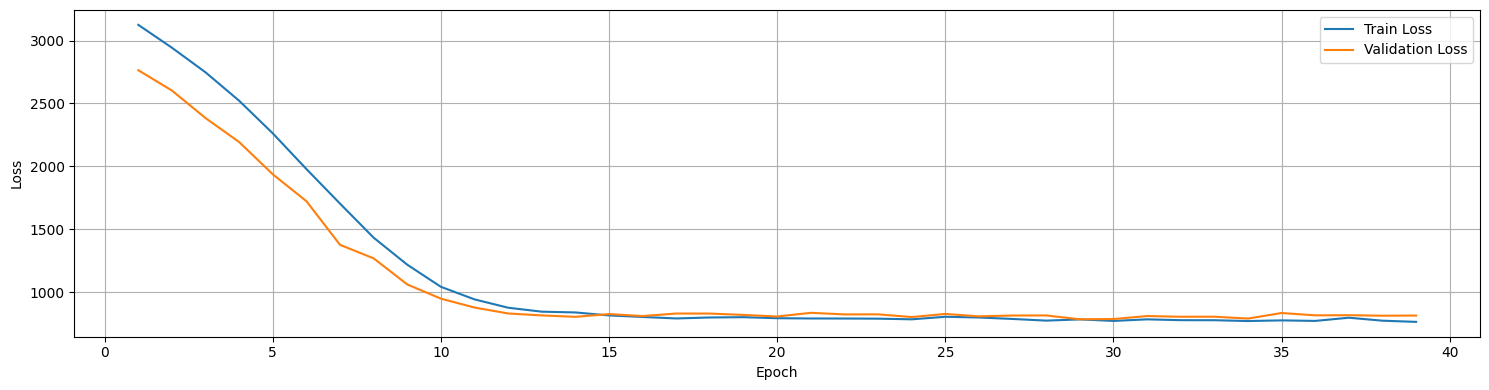

In [60]:
plt.figure(figsize=(15, 4))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()


## Store and Load the model

You have 2 ways to save your model (and trained weights):

* Save **only the weights** (`model.state_dict()`) and then, to load them, you need the class definition. You can then replace the initialized weights with the saved ones using `model.load_state_dict(best_model_state)`.
* Save **both the model and the weights** in a serialized class. You will lose information about the class definition (use this only when you need the model for inference).

Make sure to be aware of the device it’s on (CPU or GPU). When loaded, the model will be placed on the same type of device, which must be available.


In [ ]:
torch.save(model.to("cpu"), 'model.pth')

In [92]:
loaded_model = torch.load('model.pth', weights_only=False)

print(f"Model:\n {loaded_model}")

device = next(model.parameters()).device
print(f"Model Loaded on Device:{device}")

Model:
 NeuralNetwork(
  (residual): Linear(in_features=3, out_features=256, bias=True)
  (features_extraction): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=128, out_features=256, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
  )
  (head): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)
Model Loaded on Device:cpu



* **PyTorch models expect the first dimension to represent the batch size.** Even when using a single sample, the input must include this batch dimension. Therefore, if your input is a vector with `n_features`, the input tensor should have shape `(n_samples, n_features)`.

* **The model output mirrors this batch dimension.** For `n_samples` inputs and `n_targets` outputs per sample, the returned tensor will have shape `(n_samples, n_targets)`.


In [93]:
X = torch.Tensor([features_test[0]])# .to("cpu")
print (f"Input: {X} \tshape:{X.shape}")

with torch.no_grad():
    y = loaded_model(X)

print(y)

Input: tensor([[-1.3938,  0.2604,  0.4190]]) 	shape:torch.Size([1, 3])
tensor([[45.6505]])
